In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Assumptions:
- every job has *joboverheadseconds* required for getting a job to run on a node from queueing system decision
- there is an average queueing time for any eligible job

Allocatable: smallest set of workers that can be acquired from a scheduler (think: nodes)

worker: single set of cores for any calculation (think: cores)

In [2]:
#_ = np.loadtxt('data/mp2_opt_BoB_scatter.dat')
_ = np.loadtxt('../data/A_BoB.txt')
real, predicted = _[:, 0], _[:, 1]
predicted[predicted < 0] = np.median(predicted)
print (max(real)/3600)

21.227222222222224


In [3]:
params_cscs = {'joboverheadseconds': 30, 'jobqueueingtime': 60*60, 'workersperallocatable': 1}
META_TRY_HOPELESS_GAPS = True

In [4]:
# everything either perfectly parallel or perfectly serial, whichever is faster
def ideal_duration(real, predicted, numallocatables, walltime, params):
    # walltime estimation
    rs = np.sort(real)[::-1]
    workpackages = np.split(rs, np.arange(params['workersperallocatable'] * numallocatables, len(rs), params['workersperallocatable'] * numallocatables))
    packagedurations = np.array(list(map(np.max, workpackages))) + params['joboverheadseconds']
    walltotal = np.sum(packagedurations) 
    
    return {'cputime': np.sum(real), 'walltime': walltotal}
ideal_duration(real, predicted, 1000, 0, params_cscs)

1000


{'cputime': 12860344.0, 'walltime': 77912.0}

In [6]:
def greasy(real, predicted, numallocatables, walltime, params):
    # No restarts, so tasks need to fit into a single job
    assert walltime > np.max(real)
    
    numworkers = numallocatables * params['workersperallocatable']
    
    # Current walltime of a single worker
    cputimes = np.zeros(numworkers)
    # Last task durations assigned to a worker
    lasttimes = np.zeros(numworkers)
    
    # Total used walltime
    walltotal = 0. 
    
    # counter
    queueing_counter = 0
    
    # Greasy specifies jobs in a certain order
    for tasktime in np.random.permutation(real):
        fastest = np.argmin(cputimes)
        
        if cputimes[fastest] > walltime:
            # Greasy job has reached end of walltime limit, cycle all workers
            walltotal += walltime + params['joboverheadseconds']
            queueing_counter += 1
            
            cputimes = np.copy(lasttimes)
            lasttimes *= 0.
            
        # assign time to worker
        cputimes[fastest] += tasktime
        lasttimes[fastest] = tasktime
    
    if max(cputimes) > walltime:
        walltotal += walltime + params['joboverheadseconds'] 
        queueing_counter += 1
        for wid in range(numworkers):
            if cputimes[wid] > walltime:
                cputimes[wid] = lasttimes[wid]
            else:
                cputimes[wid] = 0
    
    # Greasy job is kept alive until the last worker is finished
    walltotal += np.max(cputimes) + params['joboverheadseconds']
    queueing_counter += 1
    
    return {'cputime': walltotal * numworkers, 'walltime': walltotal + queueing_counter * params['jobqueueingtime']}
greasy(real, predicted, 5, 24*3600, params_cscs)#['cputime']/ideal_duration(real, predicted, None, None)['cputime']

{'cputime': 14932440.0, 'walltime': 3112488.0}

In [7]:
# job array
def jobarray(real, predicted, numallocatables, walltime, params):
    # No restarts, so tasks need to fit into a single job
    assert walltime > np.max(real)
    
    permutation = np.random.permutation(real)
    # cputime estimation
    workpackages = np.split(permutation, np.arange(params['workersperallocatable'], len(permutation), params['workersperallocatable']))
    packagedurations = np.array(list(map(np.max, workpackages))) + params['joboverheadseconds']
    cputotal = np.sum(packagedurations) * params['workersperallocatable']
    
    # walltime estimation
    cputimes = np.zeros(numallocatables)
    counts = np.zeros(numallocatables)
    for tasktime in packagedurations:
        fastest = np.argmin(cputimes)
        cputimes[fastest] += tasktime
        counts[fastest] += 1
    walltotal = max(cputimes + counts * (params['jobqueueingtime']))
    
    return {'cputime': cputotal, 'walltime': walltotal}
jobarray(real, predicted, 1, 24*3600, params_cscs)#['cputime']/ideal_duration(real, predicted, None, None)['cputime']

{'cputime': 12894784.0, 'walltime': 17027584.0}

In [10]:
# ML packing
def ml(real, predicted, numallocatables, walltime, params):
    # No restarts, so tasks need to fit into a single job
    assert walltime > np.max(real)
    
    numworkers = numallocatables * params['workersperallocatable']
    cputimes = np.zeros(numworkers)
    lasttimes = np.zeros(numworkers)
    total = 0.
    walltotal = 0.
    
    # sort by size
    sorting = np.argsort(predicted)
    ps, rs = predicted[sorting][::-1], real[sorting][::-1]
    nofit = False
    while len(ps) > 0:
        fastest = np.argmin(cputimes)
        
        if cputimes[fastest] > walltime or nofit:
            walltotal += min(walltime, max(cputimes)) + params['joboverheadseconds'] + params['jobqueueingtime']
            total += (min(walltime, max(cputimes)) + params['joboverheadseconds']) * numworkers
            #if not META_TRY_HOPELESS_GAPS:
            #    raise ValueError('Not implemented.')
            #walltotal += walltime + params['joboverheadseconds'] + params['jobqueueingtime']
            #total += (walltime + params['joboverheadseconds']) * numworkers
            
            cputimes = np.copy(lasttimes)
            lasttimes *= 0.
            nofit = False
        
        # get largest job fitting in gap
        gap = walltime - cputimes[fastest]
        acceptable = np.where(ps <= gap)[0]
        if len(acceptable) == 0:
            if META_TRY_HOPELESS_GAPS:
                # no fit found, try the smallest one - nothing to loose
                chosen = np.argmin(ps)
            else:
                nofit = True
                lasttimes[fastest] = 0
                continue
        else:
            chosen = acceptable[0]
        
        # take real time instead of the predicted one
        cputimes[fastest] += rs[chosen]
        lasttimes[fastest] = rs[chosen]
        
        # remove this task
        ps = np.delete(ps, chosen)
        rs = np.delete(rs, chosen)
        
    if max(cputimes) > walltime:
        walltotal += walltime + params['joboverheadseconds'] + params['jobqueueingtime']
        total += (walltime + params['joboverheadseconds']) * numworkers
        for wid in range(numworkers):
            if cputimes[wid] > walltime:
                cputimes[wid] = lasttimes[wid]
            else:
                cputimes[wid] = 0    
    
    walltotal += np.max(cputimes) + params['joboverheadseconds'] + params['jobqueueingtime']
    total += (np.max(cputimes) + params['joboverheadseconds']) * numworkers
    
    return {'cputime': total, 'walltime': walltotal}

ml(real, predicted, 25, 24*3600, params_cscs)['cputime']

14513100.0

In [26]:
def randomize(func, real, predicted, nworkers, time, params):
    results = [func(np.copy(real), np.copy(predicted), np.copy(nworkers), np.copy(time), params) for _ in range(100)]
    q = pd.DataFrame(results)
    return dict(q.mean())

In [19]:
# build data
def sample_efficiency(real, predicted, parambook):
    data = []
    for cluster in parambook.label.unique():
        for hours in (0.5, 2, 6, 12, 24):
            for nworkers in 2**np.arange(8):
                params = {'joboverheadseconds': 30, 'workersperallocatable': 1}
                if cluster == 'cscs':
                    params['workersperallocatable'] = 12
                
                params['jobqueueingtime'] = parambook.query('label == @cluster & allocatable == @nworkers & timelimit == @hours').waiting.values[0]
                params['jobqueueingtime'] = parambook.query('label == @cluster & timelimit == @hours').mean().waiting
                try:
                    q = ml(np.copy(real), np.copy(predicted), np.copy(nworkers), np.copy(hours)*3600, params)
                except AssertionError:
                    continue
                data.append({'method': 'ML/redis', 'times': hours, 'workers': nworkers, 'cputime': q['cputime'], 'cluster': cluster, 'walltime': q['walltime']})

                q = randomize(jobarray, real, predicted, nworkers, hours*3600, params)
                data.append({'method': 'jobarray', 'times': hours, 'workers': nworkers, 'cputime': q['cputime'], 'cluster': cluster, 'walltime': q['walltime']})

                q = randomize(greasy, real, predicted, nworkers, hours*3600, params)
                data.append({'method': 'greasy', 'times': hours, 'workers': nworkers, 'cputime': q['cputime'], 'cluster': cluster, 'walltime': q['walltime']})

    return pd.DataFrame(data)
df = sample_efficiency(real, predicted, pd.read_csv('../data/waittimes.txt'))

## Sample run

1000


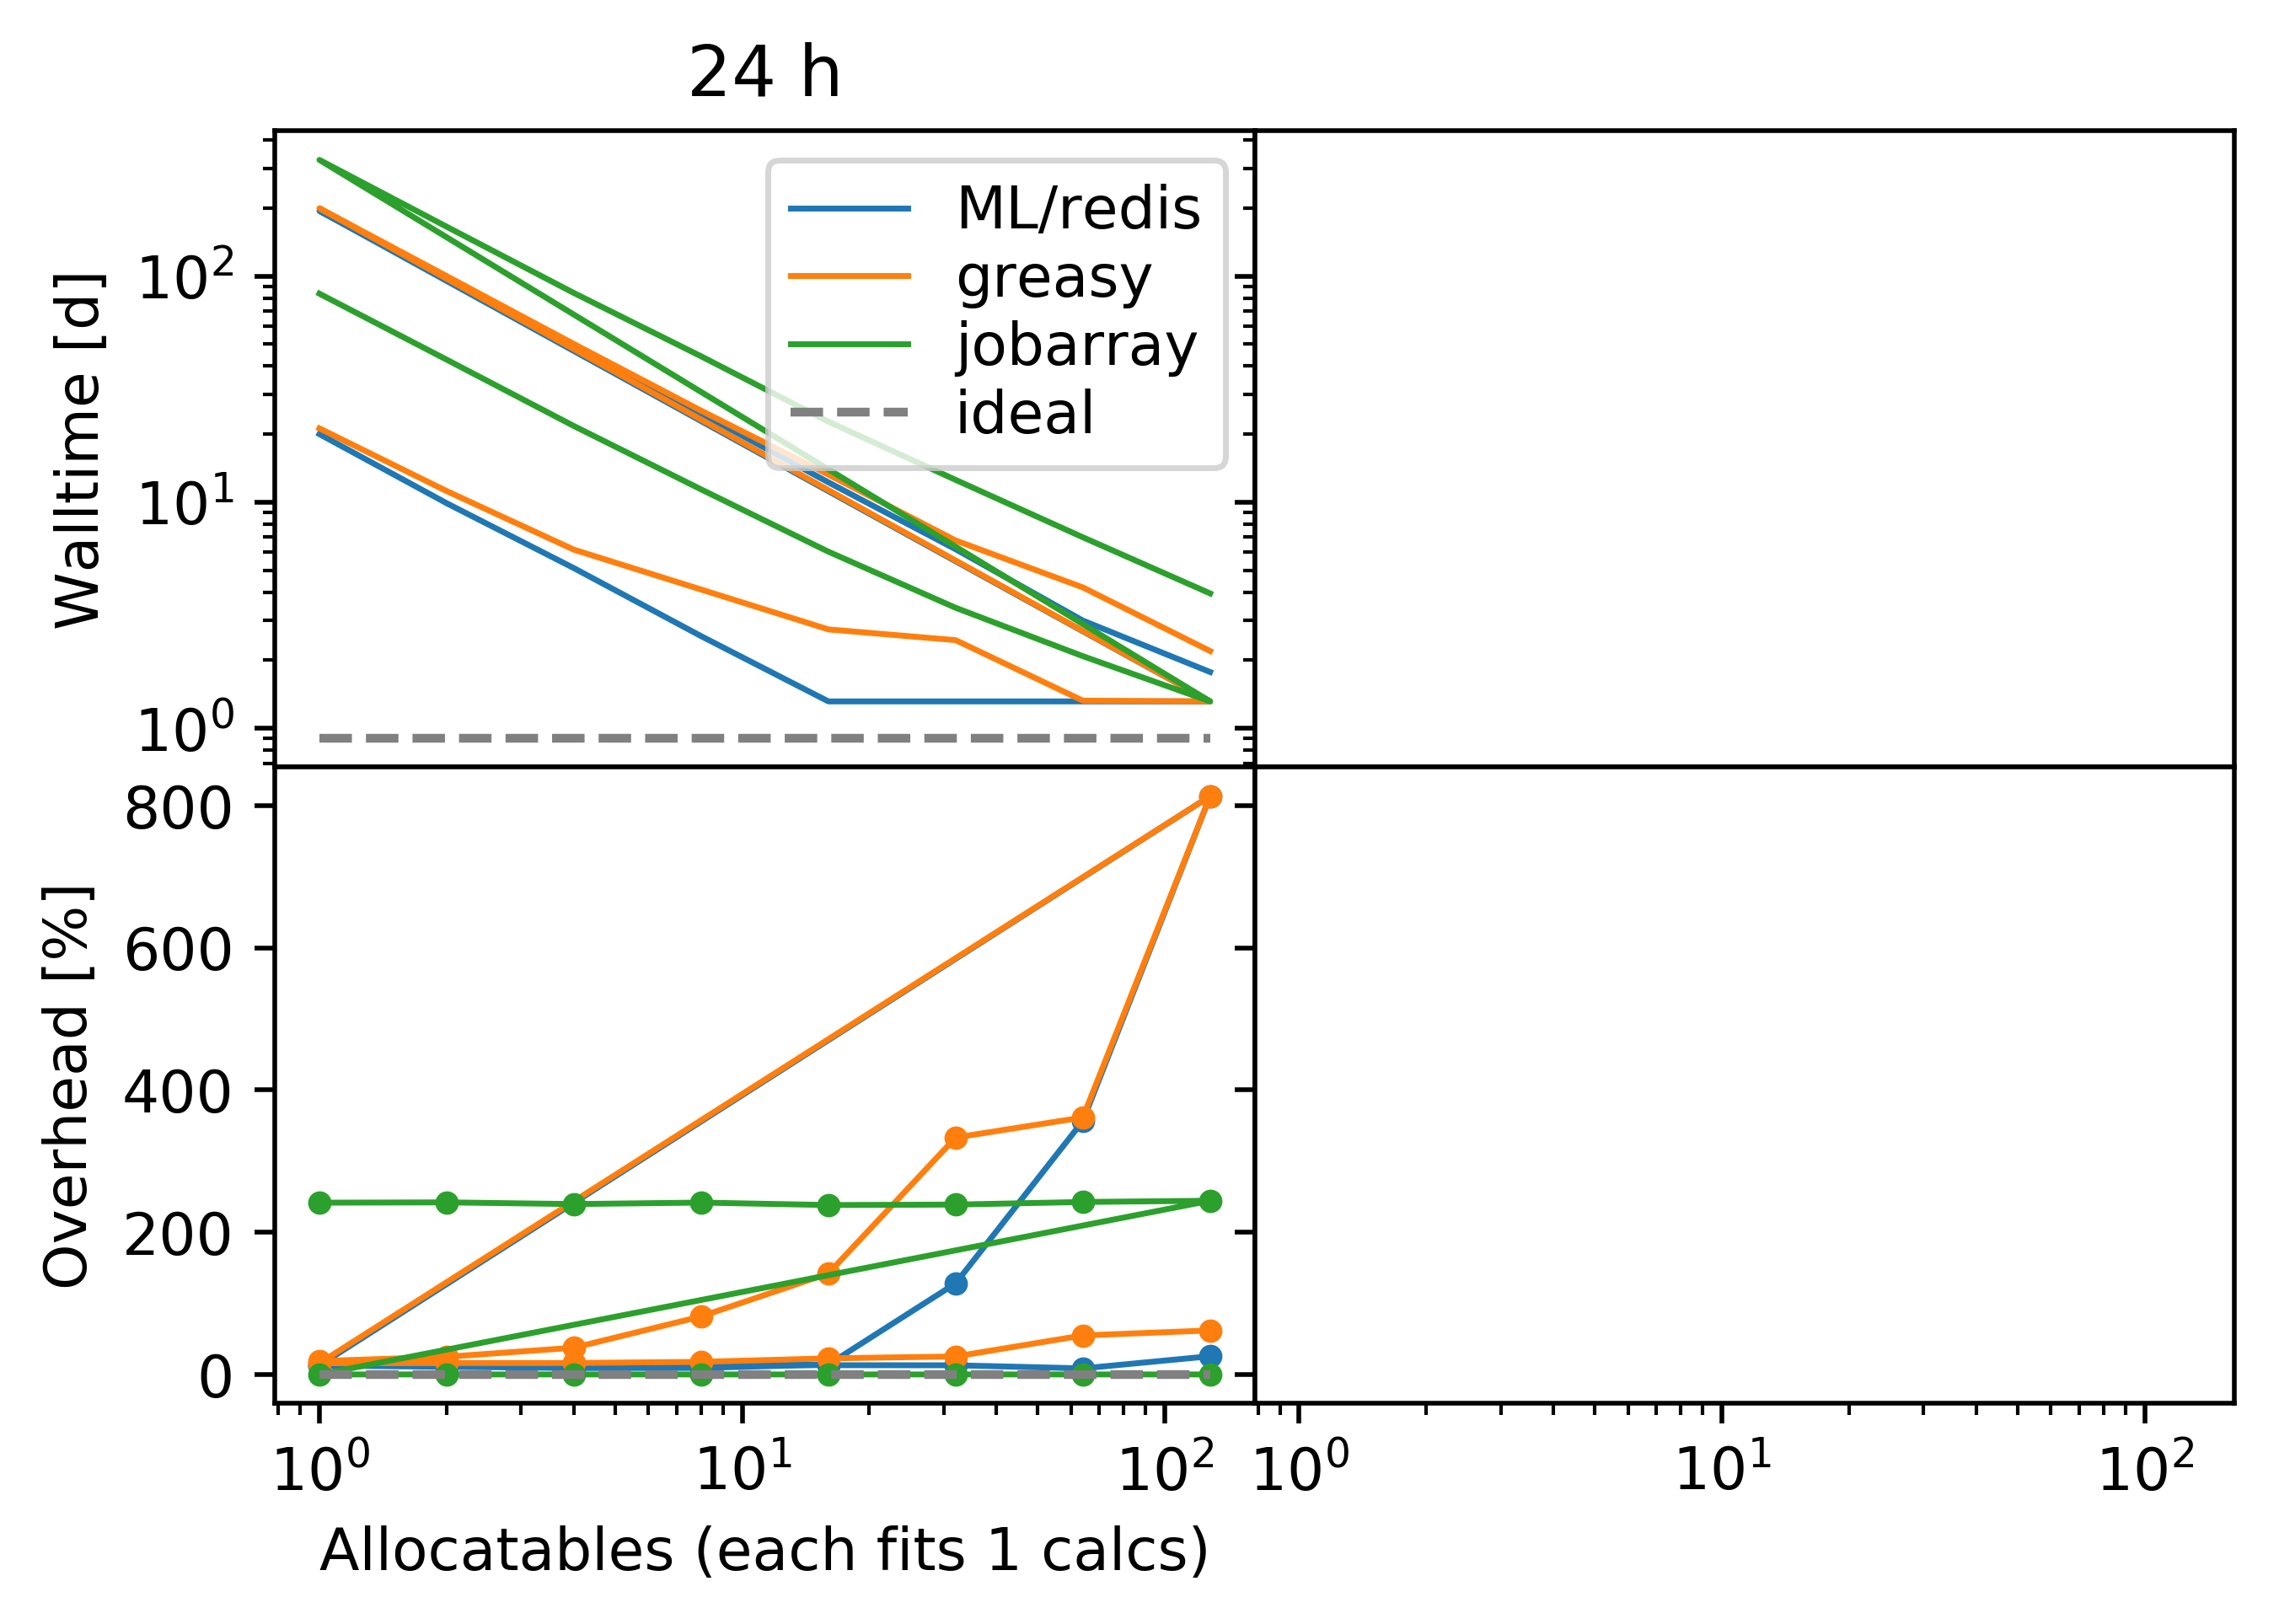

In [20]:
# workers vs walltime
ideal = ideal_duration(real, predicted, 1000, 0, params_cscs)
fig, axs = plt.subplots(2, max(2, len(df.times.unique())), dpi=500, sharex=True, sharey="row")
for tidx, times in enumerate(df.times.unique()):
    s = df.query('times == @times')
    axs[0, tidx].set_title('%s h' % times)
    
    # walltime
    for name, group in s.groupby('method'):
        axs[0, tidx].loglog(group.workers, group.walltime/3600/24, label=name, lw=1)
    axs[0,0].set_ylabel('Walltime [d]')
    axs[0, tidx].plot((df.workers.min(), df.workers.max()), (ideal['walltime']/3600/24, ideal['walltime']/3600/24),  ls='--',color='grey', label='ideal')
    
    # efficiency
    axs[1,0].set_ylabel('Overhead [%]')
    for name, group in s.groupby('method'):
        axs[1, tidx].plot(group.workers, (group.cputime / ideal['cputime']-1)*100, 'o-', markersize=3, label=name, lw=1)
    axs[1, tidx].plot((df.workers.min(), df.workers.max()), (0., 0.), '--', color='grey', label='ideal')
axs[0,tidx].legend(labelspacing=0.2)
axs[1, tidx//2].set_xlabel('Allocatables (each fits %d calcs)' % params_cscs['workersperallocatable'])
plt.subplots_adjust(wspace=0, hspace=0)

## Production implementation

In [27]:
dfs = []
ideals = []
usefiles = {'A': 'A_nfchl.txt', 'B': 'B_nfchl.txt', 'C': 'C_nfchl.txt', 'D': 'D_nfchl.txt', 'E': 'E_nfchl.txt', 'F': 'F_nfchl_cpu_to_wall.txt', 'G': 'G_nBoB_cpu_to_wall.txt',}

parambook = pd.read_csv('../data/waittimes.txt')
for dataset in 'ABCDEFG':
    print (dataset)
    _ = np.loadtxt('../data/%s' % usefiles[dataset])
    real, predicted = _[:, 0], _[:, 1]
    predicted[predicted < 0] = np.median(predicted)
    
    ideal = ideal_duration(real, predicted, 1000, None, params_cscs)
    ideal.update({'dataset': dataset})
    ideals.append(ideal)
    
    df = sample_efficiency(real, predicted, parambook)
    df['dataset'] = dataset
    dfs.append(df)
    
total = pd.concat(dfs)
total.to_csv('../data/scheduling_estimates')
ideals = pd.DataFrame(ideals)
ideals.to_csv('../data/scheduling_ideal')

A
1000
B
1000
C
1000
D
1000
E
1000
F
1000
G
1000
